**Image Pre-processing Pipeline**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import tqdm


sys.path.append('/home/common/HolschuhLab/Code/')
sys.path.append('/home/common/HolschuhLab/Code/OtherRepos/snappy/')

import NDH_Tools as ndh
from esa_snappy import ProductIO
from esa_snappy import PixelPos, GeoPos
from esa_snappy import GPF, HashMap

input_path = '/home/common/HolschuhLab/Data/Sentinel_Imagery/2025/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957.SAFE'
post_processing_folder = 'post_processing_folder/'
output_dir = post_processing_folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
base_filename = 'S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957'

input_product = ProductIO.readProduct(input_path)

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
java.net.ConnectException: Connection timed out (Connection timed out)
	at java.base/java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:412)
	at java.base/java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:255)
	at java.base/java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:237)
	at java.base/java.net.Socket.connect(Socket.java:609)
	at java.base/java.net.Socket.connect(Socket.java:558)
	at java.base/sun.net.NetworkClient.doConnect(NetworkClient.java:182)
	at java.base/sun.net.www.http.HttpClient.openServer(HttpClient.java:507)
	at java.base/sun.net.www.http.HttpClient.openServer(HttpClient.java:602)
	at java.base/sun.net.www.h

**Processing Steps to be Taken**

(1) Apply orbit file

(2) Ellipsoid Correction

(3) Thermal noise removal

(4) Radiometric calibration

(5) Speckle filtering

(6) Terrain correction

(7) Subset



**Applying Orbit File**

In [2]:
#Orbit Correction
orbit_params = HashMap()
orbit_params.put('Orbit Type', 'Sentinel Precise (Auto Download)')
orbit_params.put('Polynomial Degree', '3')
orbit_params.put('ContinueOnFail', 'false')

orbit_applied = GPF.createProduct('Apply-Orbit-File', orbit_params, input_product)
orbit_applied.setName(base_filename + '_Orb')

#save
orbit_applied_filename = output_dir + orbit_applied.getName() + '.tif'
ProductIO.writeProduct(orbit_applied, orbit_applied_filename, 'GeoTIFF')
print("Orbit product written to:", orbit_applied_filename)

[Fatal Error] :6:3: The element type "hr" must be terminated by the matching end-tag "</hr>".
SEVERE: org.esa.snap.core.dataop.downloadable.XMLSupport: cannot parse xml : The element type "hr" must be terminated by the matching end-tag "</hr>".



100% done.
Orbit product written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb.tif


**Border Noise Removal**

In [3]:
# remove Border Noise
border_params = HashMap()
bnr_product = GPF.createProduct('Remove-GRD-Border-Noise', border_params, orbit_applied)



version = 3.9

100% done.


**Calibration**

In [4]:
# Calibration
calibration_params = HashMap()
calibration_params.put('outputSigmaBand', True)
calibration_params.put('sourceBands', 'Intensity_HH')  
calibration_params.put('selectedPolarisations', 'HH')  
calibration_params.put('outputImageScaleInDb', False)


calibrated_product = GPF.createProduct('Calibration', calibration_params, bnr_product)
calibrated_product.setName(base_filename + '_Orb_Cal_BNR')
calibratedSP_filename = output_dir + calibrated_product.getName() + '.tif'
ProductIO.writeProduct(calibrated_product, calibratedSP_filename, 'GeoTIFF')
print("Calibrated written to:", calibratedSP_filename)



100% done.
Calibrated written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_Cal_BNR.tif


**Thermal Noise Removal**

In [5]:
# Noise Removal
tnr_params = HashMap() # remove antenna Thermal Noise (TNR)
tnr_params.put('selectedPolarisations', 'HH') # HH polarization
tnr_params.put('reIntroduceThermalNoise', 'false') # do not add thermal noise back
tnr_product = GPF.createProduct('ThermalNoiseRemoval', tnr_params, calibrated_product)


tnr_product.setName(base_filename + '_Orb_NR_EC_Cal')
tnr_filename = output_dir + tnr_product.getName() + '.tif'
ProductIO.writeProduct(tnr_product, tnr_filename, 'GeoTIFF')
print("Noise Removal written to:", tnr_filename)


100% done.
Noise Removal written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_NR_EC_Cal.tif


**Speckle Filtering**

In [6]:
# speckle filtering
speckle_params = HashMap()
speckle_product = GPF.createProduct('Speckle-Filter', speckle_params, tnr_product)
speckle_product.setName(base_filename + '_Orb_NR_Spk_Cal') # Update name to include _Spk

# save
SP_filename = output_dir + speckle_product.getName() + '.tif'
ProductIO.writeProduct(speckle_product, SP_filename, 'GeoTIFF')
print("Speckle Filtering written to:", SP_filename)





100% done.
Speckle Filtering written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_NR_Spk_Cal.tif


**Ellipsoid Correction**

In [7]:
ellipsoid_params = HashMap()
ellipsoid_params.put('externalDEMFile', '/home/common/HolschuhLab/Data/Antarctic_Imagery/REMA_Hillshade/REMA_200m_hillshade.nc')
ellipsoid_params.put('mapProjection', 'EPSG:3031')

ellipsoid_corrected_product = GPF.createProduct('Ellipsoid-Correction-GG', ellipsoid_params, speckle_product)
ellipsoid_corrected_product.setName(base_filename + '_Orb_Cal_Spk_NR')

#save
ecp_name = output_dir + ellipsoid_corrected_product.getName() + '.tif'
ProductIO.writeProduct(ellipsoid_corrected_product, ecp_name, 'GeoTIFF')
print("Ellipsoid product written to:", ecp_name)


100% done.
Ellipsoid product written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_Cal_Spk_NR.tif


**Adding BandMath to speckle filtering and calibration**

In [8]:
from esa_snappy import jpy

# SP filtering w/ Calibration and Bandmaths
bandmath_params = HashMap()

BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
targetBand = BandDescriptor()
targetBand.name = 'Sigma0_HH_8bit'
targetBand.type = 'uint8'
targetBand.expression = 'Sigma0_HH * 255'
targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)

targetBands[0] = targetBand

bandmath_params.put('targetBands', targetBands)

# band_names = calibrated_product.getBandNames()
# for i in range(len(band_names)):
#     print(band_names[i])

# apply BandMaths
bandmath_product = GPF.createProduct('BandMaths', bandmath_params, ellipsoid_corrected_product)

# save output
bandmath_product.setName(base_filename + '_Orb_NR_Spk_Cal_EC_BandMath')
bandmath_filename = output_dir + bandmath_product.getName() + '.tif'
ProductIO.writeProduct(bandmath_product, bandmath_filename, 'GeoTIFF')

print("Step 5 written to:", bandmath_filename)


100% done.
Step 5 written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_NR_Spk_Cal_EC_BandMath.tif


**Loading Image**

('band', 'y', 'x')


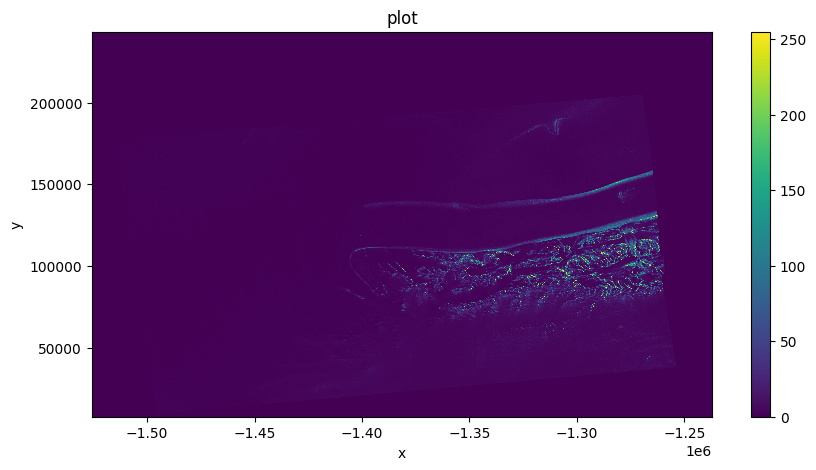

In [10]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# load post processed raster image
relative_data_path = 'S1A_IW_GRDH_1SSH_20250107T062838_20250107T062903_057334_070E2B_9957_Orb_NR_Spk_Cal_EC_BandMath.tif'
load_data_path = output_dir + relative_data_path
data = rxr.open_rasterio(load_data_path)


print(data.dims)

# plotting
plt.figure(figsize=(10, 5))
data.plot(vmin=0, vmax=255)
plt.title("plot")
plt.show()




In [ ]:
print(data.min().item(), data.max().item())

In [ ]:
plt.hist(data.values.ravel(),np.arange(0,255))